# Fashion MNIST Classification
In this notebook, I will be using PyTorch to create a model that classifies clothing images from the fashion MNIST dataset. We will start by downloading the data, and adding that to DataLoaders

In [1]:
import torch
import torchvision
from torchvision import transforms
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

c:\Users\qmirz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, let's define some global variables which will be useful when keeping track of the models output shapes

In [2]:
img_size = train_data[0][0].shape[1]
num_classes = len(train_data.classes)
input_size = train_data[0][0].shape[0]

print(f"Image Size:{img_size}x{img_size}\nNumber of Classes:{num_classes}\nInput Size: {input_size} channel(s)")

Image Size:28x28
Number of Classes:10
Input Size: 1 channel(s)


We can now define the model class, I'm going to train my own model which consists of 2 convolutional blocks and a single fully connected layer, we'll then see how it goes from there. I may also implement a transfer learning approach using resnet-50 to try and increase the accuracy!

In [3]:
import torch.nn as nn
class MultiClassCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=2, stride=2) # 16X14X14
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x7x7
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2) # 32x3x3
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x1x1

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [4]:
# Instantiate the model
model = MultiClassCNN(input_size, num_classes)
print(model)

MultiClassCNN(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)


Coming from tensorflow, I always found looking at the model summary to be helpful to improve the interpretability of our model. In PyTorch, I found that by calling summary on the model, with your desired input size, it acts as a form of sanity check that ensures your model has the right output channel as the feature vectors propagates through the layers. 

If it's incorrect, summary() will error and tell you why the model isn't right which is so helpful!

In [5]:
from torchsummary import summary
summary(model, (input_size, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]              80
              ReLU-2           [-1, 16, 14, 14]               0
         MaxPool2d-3             [-1, 16, 7, 7]               0
            Conv2d-4             [-1, 32, 3, 3]           4,640
              ReLU-5             [-1, 32, 3, 3]               0
         MaxPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 5,050
Trainable params: 5,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.02
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


Set the device, I actually am training this on my local device and do not have cuda available so setting the device as I did below in a sense doesn't really matter. However, if in future I'm working with GPUs for parallel computing, I think it's going to be important to be able to recall simple syntax like the below

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with that out of the way, we can begin the training loop

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_total_steps = len(train_loader)
num_epochs = 100
losses_per_epoch = []
acc_per_epoch = []

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Count correct predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    # Calculate accuracy
    accuracy = 100 * total_correct / total_samples
    acc_per_epoch.append(accuracy)
    
    losses_per_epoch.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%')


Epoch [1/100], Step [100/938], Loss: 1.8921
Epoch [1/100], Step [200/938], Loss: 1.0856
Epoch [1/100], Step [300/938], Loss: 1.0803
Epoch [1/100], Step [400/938], Loss: 0.9956
Epoch [1/100], Step [500/938], Loss: 0.7600
Epoch [1/100], Step [600/938], Loss: 0.9269
Epoch [1/100], Step [700/938], Loss: 0.7837
Epoch [1/100], Step [800/938], Loss: 0.6141
Epoch [1/100], Step [900/938], Loss: 0.7067
Epoch [1/100], Accuracy: 64.99%
Epoch [2/100], Step [100/938], Loss: 0.7540
Epoch [2/100], Step [200/938], Loss: 0.7528
Epoch [2/100], Step [300/938], Loss: 0.5660
Epoch [2/100], Step [400/938], Loss: 0.6097
Epoch [2/100], Step [500/938], Loss: 0.5925
Epoch [2/100], Step [600/938], Loss: 0.7343
Epoch [2/100], Step [700/938], Loss: 0.5612
Epoch [2/100], Step [800/938], Loss: 0.5100
Epoch [2/100], Step [900/938], Loss: 0.6355
Epoch [2/100], Accuracy: 76.19%
Epoch [3/100], Step [100/938], Loss: 0.4900
Epoch [3/100], Step [200/938], Loss: 0.8013
Epoch [3/100], Step [300/938], Loss: 0.4951
Epoch [3/100

I used many epochs just for fun, obviously I run the risk of overfitting the data though. We can verify if this is true when we compare it to the test data later hehe.

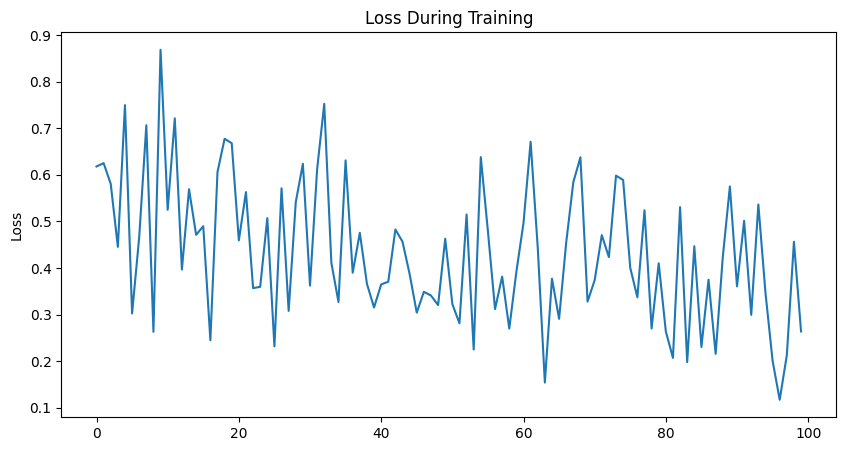

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.ylabel("Loss")
plt.plot(losses_per_epoch, label="Loss")
plt.show()


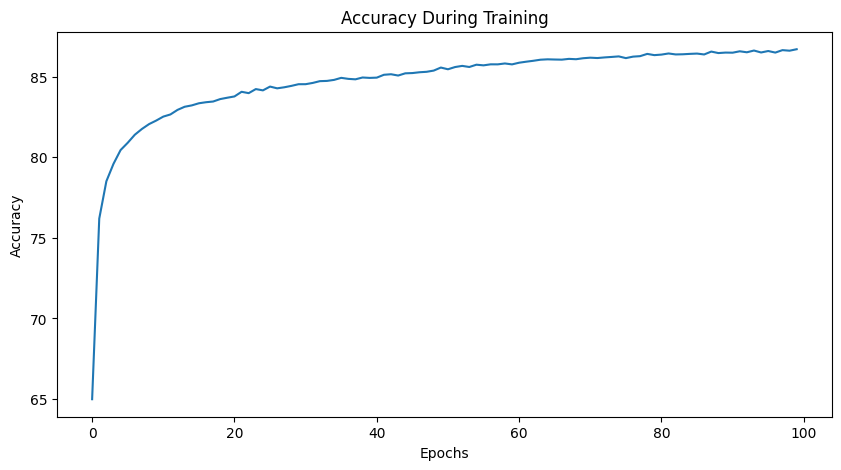

In [9]:
# plot accuracy 
plt.figure(figsize=(10, 5))
plt.plot(acc_per_epoch, label='accuracy')
plt.title("Accuracy During Training")
plt.ylabel('Accuracy')
plt.xlabel("Epochs")
plt.show()

In [10]:
# Evaluate the model
model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 84.84 %


Since the difference between our model train accuracy and test accuracy is low, we can say that the model did not overfit even after 100 epochs. However, the upshot of this is that the model is not performing that good. Relatively low training accuracy and test accuracy implies that the model is underfitting and there's high bias. Hence, let's now implement a transfer learning approach using resnet!